# User segmentation based on node roles in the peer-to-peer payment network
## Utilize Neo4j Graph Data Science library to identify node roles and use them as features for the user segmentation process
Knowing your users is vital to any business. When your users can interact with each other like on a social media platform, content sharing platform, or even work-related platforms, you can construct a network between your users and extract graph-based features to segment your users. Of course, these same approaches can be applied to other platforms that are not user-centric. In this blog post, I will walk you through the user segmentation process of a peer-to-peer payment platform through network analysis

On a peer-to-peer platform, users can digitally transfer money online to anyone else on the platform. Such platforms have gained a lot of popularity in recent years. Examples of real-world peer-to-peer payment platforms are Venmo, Paypal, and Revolut.

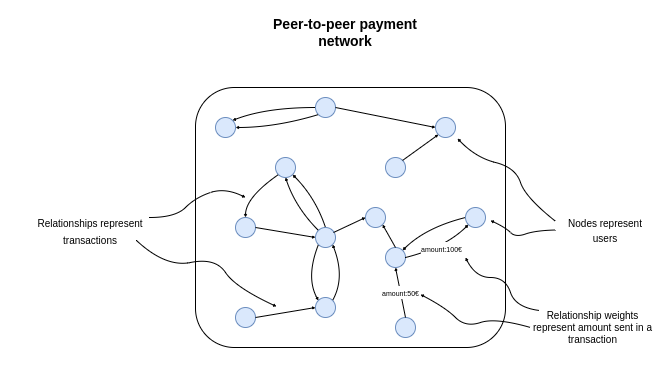

We can represent the transactions between users as a network where nodes represent users, and the relationships represent transactions. The connections have a weight or a property that contains the information about the total amount sent. If your dataset includes the timeline information, you could also add the dates of transactions to the relationships.

In order to segment the users in the network, we need to come up with features that describe the position and the role of users in the network. In general, we could take advantage of unsupervised algorithms that auto-magically encode node positions and roles in the network as a vector. However, the problem with the unsupervised approach to feature engineering is that it's hard to explain the results. For this reason, we will manually construct feature vectors for users. We can encode anything in the feature vectors we deem descriptive of user roles in the network. For example, in a peer-to-peer payment network, it makes sense to encode how many transactions and their values a user has but also look at which users connect different communities and act as a bridge between them. In this example, we will combine some simple statistics like the average transaction value of a user with outputs of graph algorithms like the Betweenness centrality to encode the user roles in the network.

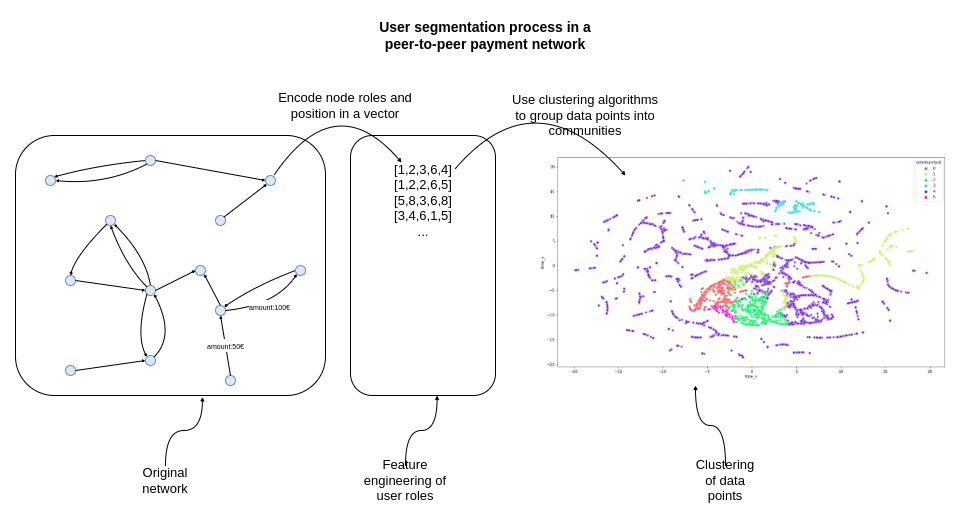

As mentioned, we need to encode user roles and positions in the network as vectors. In this post, we will manually construct features describing nodes. These features are:
* Average transaction amount
* Years since first transaction
* Weighted in-degree (total amount received)
* Weighted out-degree (total amount sent)
* Betweenness centrality
* Closeness centrality

We will use these six features to encode node roles and positions in the network. The average transaction amount and the years since first transaction features are used to capture how old are accounts and how much on average they send. Next, we will use the weighted in and out-degrees to encode the total amount sent and received by the user. Lastly, we will use the Closeness and Betweenness centralities algorithms to encode the node position in the network.

After the feature engineering process is completed, we will use the k-means algorithm to cluster the data points into groups or communities of users. These communities will represent various segments of users on the platform.

## Environment setup
We will be using Neo4j as the database to store the peer-to-peer network. Therefore, I suggest you download and install the Neo4j Desktop application if you want to follow along with the code examples.
The dataset is available as a [database dump](https://drive.google.com/file/d/1apR3xwWEOdi_WKmIAGk1bPqhHQSgxwT-/view?usp=share_link). It is a variation of the database dump available on Neo4j's product example GitHub to showcase fraud detection.

I've written a post about restoring a database dump in Neo4j Desktop sometime ago if you need some help. After you have restored the database dump, you will also need to install the Graph Data Science and APOC libraries. Make sure you are using version 2.3.0 of the GDS library or later.

You will need to have the following three Python libraries installed:
* graphdatascience: Neo4j Graph Data Science Python client
* seaborn: Visualization library
* scikit-learn: We will use t-SNE dimensionality reduction

In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
from graphdatascience import GraphDataScience

import warnings

warnings.filterwarnings("ignore")

## Setting up the connection to Neo4j

Now we are ready to start coding. First, we need to define the connections to the Neo4j instance with the graphdatascience library.

In [2]:
host = "bolt://localhost:7687"
user = "neo4j"
password = "pleaseletmein"

gds = GraphDataScience(host, auth=(user, password))

print(gds.version())

2.3.0


We need to fill in the credentials to define the connection to the Neo4j instance. Make sure to change the `password` variable to the appropriate value. I like to print the `gds.version()` method to make sure that the connection is valid and the target database has the Graph Data Science library installed.

We can quickly evaluate the populated graph schema with the `apoc.meta.stats` procedure.

In [3]:
schema = gds.run_cypher("""
CALL apoc.meta.stats()
YIELD labels, relTypesCount
"""
)

print(schema["labels"].to_list())
print(schema["relTypesCount"].to_list())

[{'User': 33732, 'Device': 51451, 'IP': 585855, 'Card': 118818}]
[{'HAS_IP': 1488949, 'REFERRED': 1870, 'USED': 55026, 'HAS_CC': 128066, 'P2P': 102832}]


There are 33732 users in the database and 102832 P2P transactions. There could be multiple P2P transactions between a pair of users. Therefore, we are dealing with a directed weighted multigraph. We have some additional information about the users available such as which IPs, credit cards, and devices they have used.

## Feature engineering

We will now move on to calculating user features used for segmentation. The first two features we will extract are the account age, calculated by looking at the first transaction, and the average transaction amount. We will use a single Cypher statement to calculate them and store them as node properties in the database.

The `gds` object has a run_cyphermethod that allows you to execute any Cypher statements.

In [4]:
gds.run_cypher("""
MATCH (u:User)
OPTIONAL MATCH (u)-[r:P2P]->(receiver)
WITH u,
     date().year - min(r.transactionDateTime).year AS accountYears,
     avg(r.totalAmount) AS avgTransactionAmount
// store as node property
SET u.accountYears = coalesce(accountYears, 0),
    u.avgTransactionAmount = coalesce(avgTransactionAmount,0)
"""
)

""


The remaining four attributes will be calculated by executing graph algorithms available in the GDS library. The graphdatascience library allows you to execute any GDS procedure and algorithm using pure Python code. I have written an [article on mapping GDS syntax from Cypher statements to pure Python code](https://medium.com/neo4j/how-to-get-started-with-the-neo4j-graph-data-science-python-client-56209d9b0d0d) to help you with the transition.

First, we need to project an in-memory graph. The projected graph schema will be relatively simple and will contain only *User* nodes and *P2P* relationships. In addition, we will include node properties *accountYears* and *avgTransactionAmount* and relationship property *totalAmount* in the projection.

In [5]:
G, res = gds.graph.project(
    "p2p",
    "User",
    "P2P",
    relationshipProperties=["totalAmount"],
    nodeProperties=["avgTransactionAmount", "accountYears"],
)
print(res)

nodeProjection            {'User': {'label': 'User', 'properties': {'avg...
relationshipProjection    {'P2P': {'orientation': 'NATURAL', 'indexInver...
graphName                                                               p2p
nodeCount                                                             33732
relationshipCount                                                    102832
projectMillis                                                           391
Name: 0, dtype: object


Since we want to use network features like the Betweenness and Closeness centrality for user segmentation, we will first evaluate how connected our network is using the Weakly Connected Components algorithm. The Weakly Connected Components algorithm is used to find disconnected parts or islands in the network and can help you evaluate overall how connected the network is.

We will use the *mutate* mode of the Weakly Connected Components algorithm, which stores the results to the projected graph and returns high-level statistics of the algorithm result.

In [6]:
wcc = gds.wcc.mutate(G, mutateProperty="wcc")

print(wcc["componentCount"])
print(wcc["componentDistribution"])

7743
{'p99': 12, 'min': 1, 'max': 11311, 'mean': 4.3564509879891515, 'p90': 4, 'p50': 2, 'p999': 46, 'p95': 6, 'p75': 3}


There are 7743 disconnected components in our P2P network. That is a high and slightly unexpected amount of disconnected components as there are only around 30 thousand users in the network. The largest component has 11311 members, about 30% of the population, while other components are tiny and contain only a few members. We notice that 99% of communities have 12 or fewer members.

Since we want to segment our users based on their network features, we will focus our analysis on the largest component only and ignore the rest. This is because the network attributes are not very descriptive when dealing with small components that contain five members. More importantly, I want to show you how to filter the largest component in your projected graph. However, you could always run your analysis on the whole network if you wanted, or that was the requirement.

The subgraph filter projection procedure allows us to filter projected graphs on mutated properties. In this example, we will select only nodes that are part of the largest component. Then, the subgraph filter projection creates a new graph based on the specified predicates.

In [7]:
largestComponentId = (
    gds.graph.streamNodeProperty(G, "wcc")
    .groupby("propertyValue")
    .size()
    .to_frame("componentSize")
    .reset_index()
    .sort_values(by="componentSize", ascending=False)["propertyValue"][0]
)

largestComponentGraph, res = gds.beta.graph.project.subgraph(
    "largestComponent", G, f"n.wcc = {largestComponentId}", "*"
)

First, we needed to fetch the id of the largest component. We can retrieve mutated properties from the projected graph using the `gds.graph.streamNodeProperty` method. Next, we applied a simple aggregation and sorting to extract the particular component id and then use it as an input to the subgraph filter projection method.

Now that we have the projected graph containing only the largest component ready, we can extract the network features. We will begin by calculating the weighted in and out-degrees. Again, we will use the `mutate` mode of the algorithm to store the results back to the projected graph.

In [8]:
gds.degree.mutate(
    largestComponentGraph,
    relationshipWeightProperty="totalAmount",
    mutateProperty="weightedOutdegree",
)

gds.degree.mutate(
    largestComponentGraph,
    orientation="REVERSE",
    relationshipWeightProperty="totalAmount",
    mutateProperty="weightedIndegree",
)

nodePropertiesWritten                                                 11311
centralityDistribution    {'p99': 28470.124969482422, 'min': 0.0, 'max':...
mutateMillis                                                              0
postProcessingMillis                                                    175
preProcessingMillis                                                       0
computeMillis                                                            27
configuration             {'jobId': '55113c6d-1391-427a-9656-dba513d5355...
Name: 0, dtype: object

The only two features we need to calculate are the Betweenness and Closeness centralities. The Betweenness centrality is used to find bridges in the network connecting different community nodes.

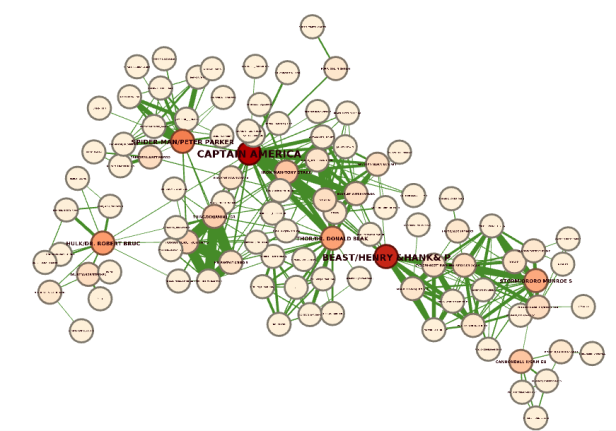

This example visualized a Marvel network, where relationships represent which characters appeared together in a comic. A prime example of Betweenness centrality is the character Beast, which connects the right-hand-side community with the other part of the network. If he was removed from the network, there would be no connection between the two communities. We can say that character Beast acts as a bridge between the two communities.

Closeness centrality is a way to identify nodes close to all the other nodes in the network and, therefore, have the option to spread the information to the network efficiently. The idea is that the information only spreads through the shortest paths between pairs of nodes.

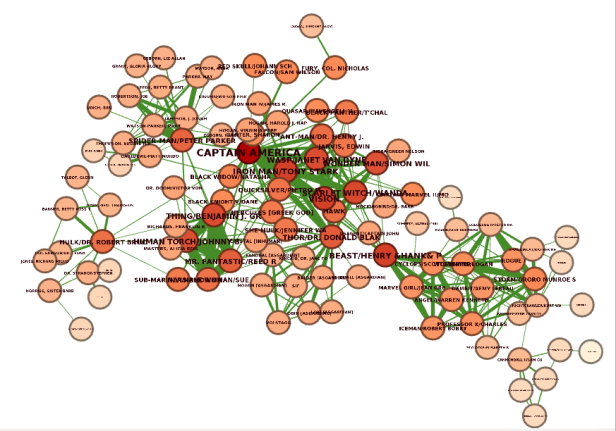

We can observe that nodes in the center of the network have the highest Closeness centrality score as they are able to reach all the other nodes the fastest.

We calculate the Closeness and Betweenness centrality score with the following code:

In [9]:
gds.betweenness.mutate(largestComponentGraph, mutateProperty="betweenness")
gds.beta.closeness.mutate(largestComponentGraph, mutateProperty="closeness")

BetweennessCentrality:   0%|          | 0/100 [00:00<?, ?%/s]

nodePropertiesWritten                                                 11311
mutateProperty                                                    closeness
centralityDistribution    {'p99': 1.0000073909759521, 'min': 0.0, 'max':...
mutateMillis                                                              0
postProcessingMillis                                                     31
preProcessingMillis                                                       0
computeMillis                                                          2205
configuration             {'jobId': '2e1cf475-2353-469e-a169-9f0895a5d3d...
Name: 0, dtype: object

## Feature exploration
Before we move on to the k-means clustering part, we will quickly evaluate the distributions of our features. We can fetch multiple mutated properties from the projected graph using the `gds.graph.streamNodeProperties` method.

In [10]:
features_df = gds.graph.streamNodeProperties(
    largestComponentGraph,
    [
        "weightedOutdegree",
        "weightedIndegree",
        "avgTransactionAmount",
        "accountYears",
        "betweenness",
        "closeness",
    ],
)
features_df.head()

,nodeId,nodeProperty,propertyValue
0,20000,weightedOutdegree,0.0
1,20000,weightedIndegree,200.0
2,20000,avgTransactionAmount,0.0
3,20000,accountYears,0.0
4,20000,betweenness,0.0


We can use the `features_df` dataframe to visualize the distributions of our features.

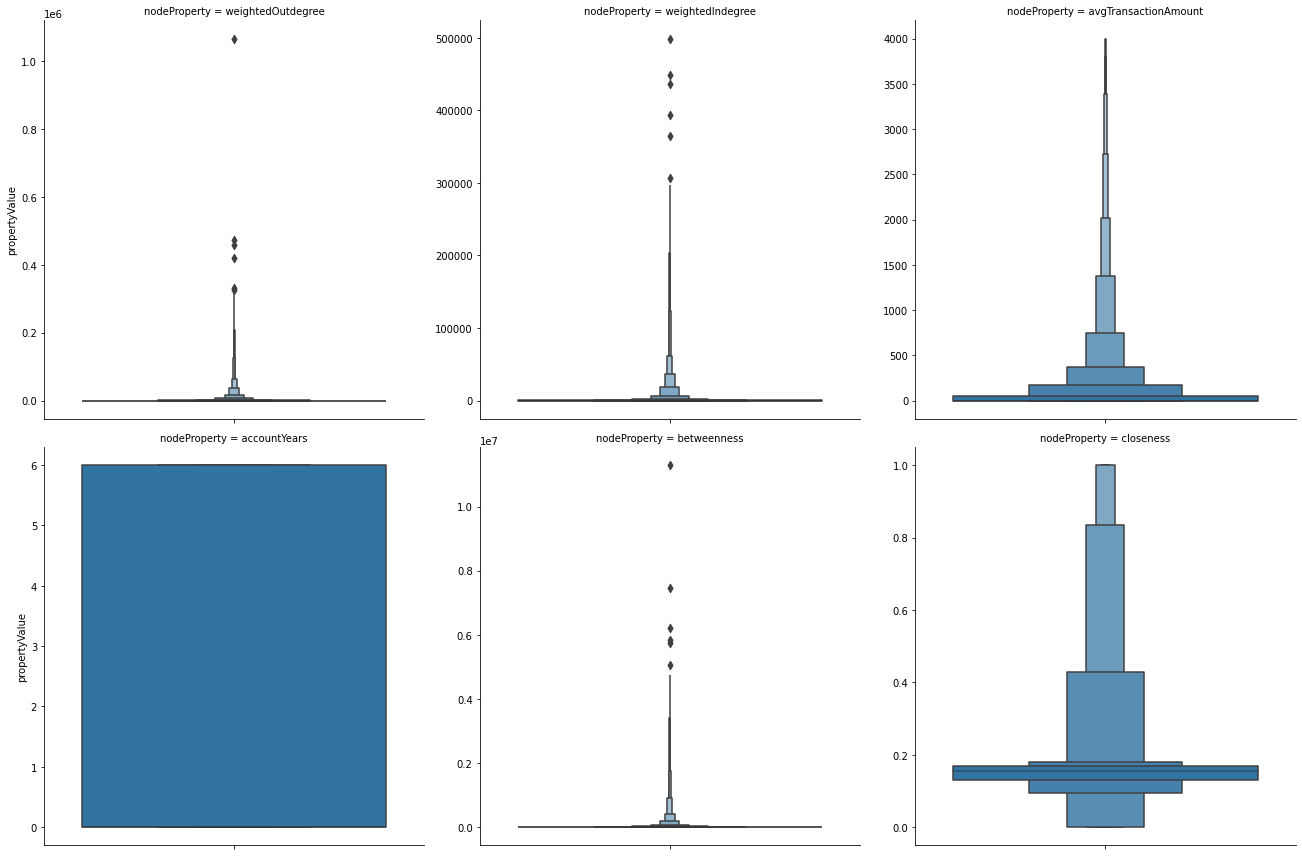

In [11]:
sns.catplot(
    col="nodeProperty",
    y="propertyValue",
    height=6,
    data=features_df,
    kind="boxen",
    sharey=False,
    col_wrap=3,
)

Interestingly, the account age is equally distributed through the years. Most users have a small average transaction amount of only a couple hundred. However, some outliers have an average transaction amount of more than 3000. We have a few outliers in the weighted out-degree with more than half a million of value sent. The dataset doesn't contain the currency, so I can't say if we are dealing with USD or not.

The `gds.graph.streamNodeProperties` has a special keyword *separate_property_columns* attribute that pivots the dataframe automatically for us. Let's try it out.

In [12]:
pivot_features_df = gds.graph.streamNodeProperties(
    largestComponentGraph,
    [
        "weightedOutdegree",
        "weightedIndegree",
        "avgTransactionAmount",
        "accountYears",
        "betweenness",
        "closeness",
    ],
    separate_property_columns=True,
)
pivot_features_df.head()

,nodeId,accountYears,avgTransactionAmount,betweenness,closeness,weightedIndegree,weightedOutdegree
0,0,5.0,98.782609,24985.335938,0.163444,1000.00,2272.0
1,1,5.0,100.000000,0.000000,0.075315,100.00,100.0
2,3,5.0,122.000000,0.000000,0.137684,167.22,122.0
3,4,0.0,0.000000,0.000000,0.171180,210.00,0.0
4,14,5.0,368.000000,0.000000,0.172998,500.00,2576.0


If you are not that visually oriented and want to get a table of distribution statistics, you can use the describe method of the dataframe.

In [13]:
pivot_features_df.describe()

,nodeId,accountYears,avgTransactionAmount,betweenness,closeness,weightedIndegree,weightedOutdegree
count,11311.000000,11311.000000,11311.000000,1.131100e+04,11311.000000,11311.000000,1.131100e+04
mean,16789.334542,2.693307,99.198514,1.967391e+04,0.180162,1527.190995,1.527191e+03
std,9749.632411,2.843814,331.473144,2.176740e+05,0.175071,13206.700185,1.637541e+04
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,8308.000000,0.000000,0.000000,0.000000e+00,0.129951,5.000000,0.000000e+00
50%,16756.000000,0.000000,0.000000,0.000000e+00,0.155281,30.000000,0.000000e+00
75%,25289.000000,6.000000,54.687500,0.000000e+00,0.170334,300.000000,1.390000e+02
max,33724.000000,6.000000,4000.000000,1.129122e+07,1.000000,498911.090000,1.065990e+06


The pivot dataframe structure is also handy when we want to visualize the correlation matrix.

<AxesSubplot:>

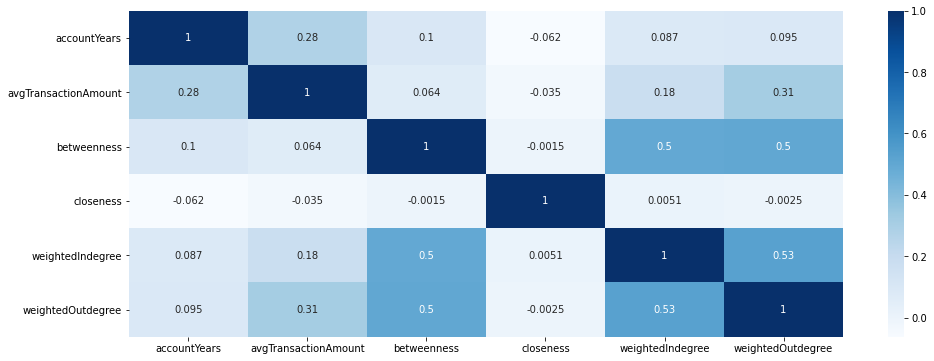

In [14]:
plt.figure(figsize=(16, 6))

corr = pivot_features_df.drop("nodeId", axis=1).corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    cmap="Blues",
    annot=True,
)

We can observe that the Betweenness centrality correlates with both the weighted in and out-degrees. Other than that, it seems that our features are not that correlated.
## K-means clustering
K-means clustering is a widely used technique to group or cluster data points. However, since there are no training labels to learn from, the K-means algorithm is regarded as an unsupervised machine learning algorithm. The algorithm starts with the first group of randomly selected centroids used as baseline points for every cluster. The number of clusters is a fixed number defined with the parameter k. The algorithm then assigns each data point to the nearest centroid and then iteratively optimizes the position of centroids.

There are plenty of great resources on the web about the k-means algorithm, so I won't go into detail about how it works.

One crucial thing to understand how it differs from other community detection algorithms like the Louvain or Label Propagation algorithms is that instead of using a graph of nodes and relationships as an input, we need to input vectors (array of numbers) of features that describe each data point.

Before running the k-means algorithm, we need to standardize our features so that some features with high values will not skew the results. Therefore, we will use the standard score scaler, which is available in the GDS library.

In [15]:
gds.alpha.scaleProperties.mutate(
    largestComponentGraph,
    mutateProperty="features",
    nodeProperties=[
        "weightedOutdegree",
        "weightedIndegree",
        "avgTransactionAmount",
        "accountYears",
        "betweenness",
        "closeness",
    ],
    scaler="StdScore",
)

nodePropertiesWritten                                                11311
mutateMillis                                                             0
postProcessingMillis                                                     0
preProcessingMillis                                                      0
computeMillis                                                           20
configuration            {'jobId': '2cb069c4-39e3-444b-b674-a75a2b96ad5...
Name: 0, dtype: object

We have selected our six features to be scaled and mutated under the features node property in the projected graph. The features node property type is a vector or an array of numbers.

The only thing left to do is to execute the k-means algorithm. We need to define how many clusters we want to identify by specifying the parameter k. For the purpose of blog presentability, I will use a smaller value of 6. However, you should probably use a larger number when you don't need to sacrifice accuracy for blog presentability like me.

In [16]:
kmeans_df = gds.beta.kmeans.stream(
    largestComponentGraph, nodeProperty="features", k=6, randomSeed=42
)
kmeans_df.head()

,nodeId,communityId,distanceFromCentroid,silhouette
0,20000,2,0.005067,-1.0
1,20011,0,1.148309,-1.0
2,20014,2,0.026275,-1.0
3,20017,5,0.087512,-1.0
4,20026,1,0.225664,-1.0


## Inspect cluster results
We will begin the cluster analysis by evaluating the size of clusters. First, we need to merge the `kmeans_df` dataframe with the `pivot_features_df`. Next, we use a simple groupby aggregation to calculate the size of clusters.

In [17]:
merged_df = pivot_features_df.merge(kmeans_df, on="nodeId")

merged_df.drop("nodeId", axis=1).groupby("communityId").size().to_frame(
    "communitySize"
).reset_index()

,communityId,communitySize
0,0,375
1,1,4792
2,2,3637
3,3,348
4,4,236
5,5,1923


The cluster sizes vary from 217 members all the way to 4870 members. While we could calculate statistics of features for every community, it is tough to compress the results and make them presentable in a blog. Therefore, we will first evaluate the weighted out-degree (total amount sent to other users) per cluster.

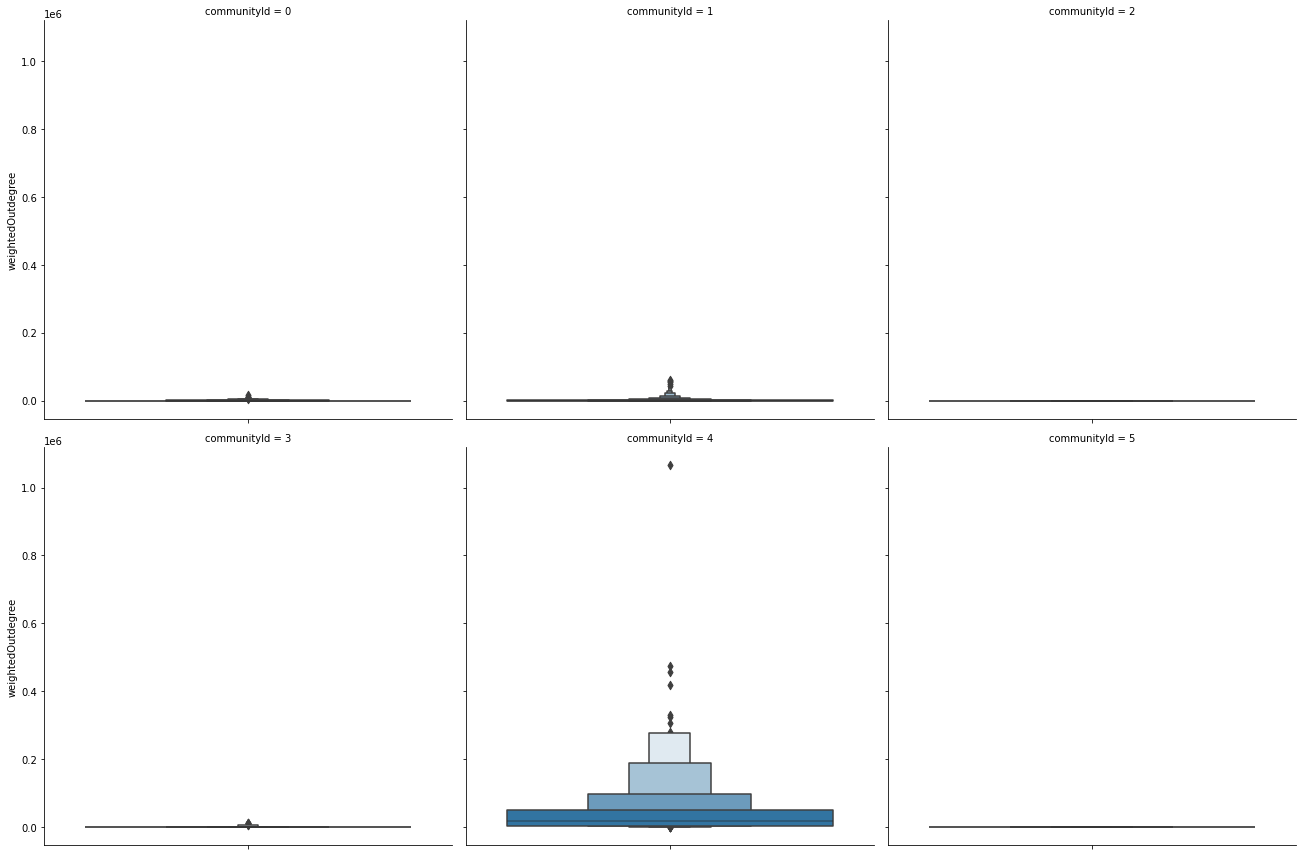

In [18]:
sns.catplot(
    col="communityId",
    y="weightedOutdegree",
    height=6,
    data=merged_df,
    kind="boxen",
    col_wrap=3,
)

Users in communities 3 and 5 have no outgoing transactions as their total amount sent to other users is zero. Communities 1 and 2 represent users that sent a small amount to other users. On the other hand, the community with id 4 represents power users who sent vast amounts to other users.

Let's say we are interested in learning more about the power users community. We can use Pandas methods to filter and transform the data to an appropriate structure to be visualized with the Seaborn library.

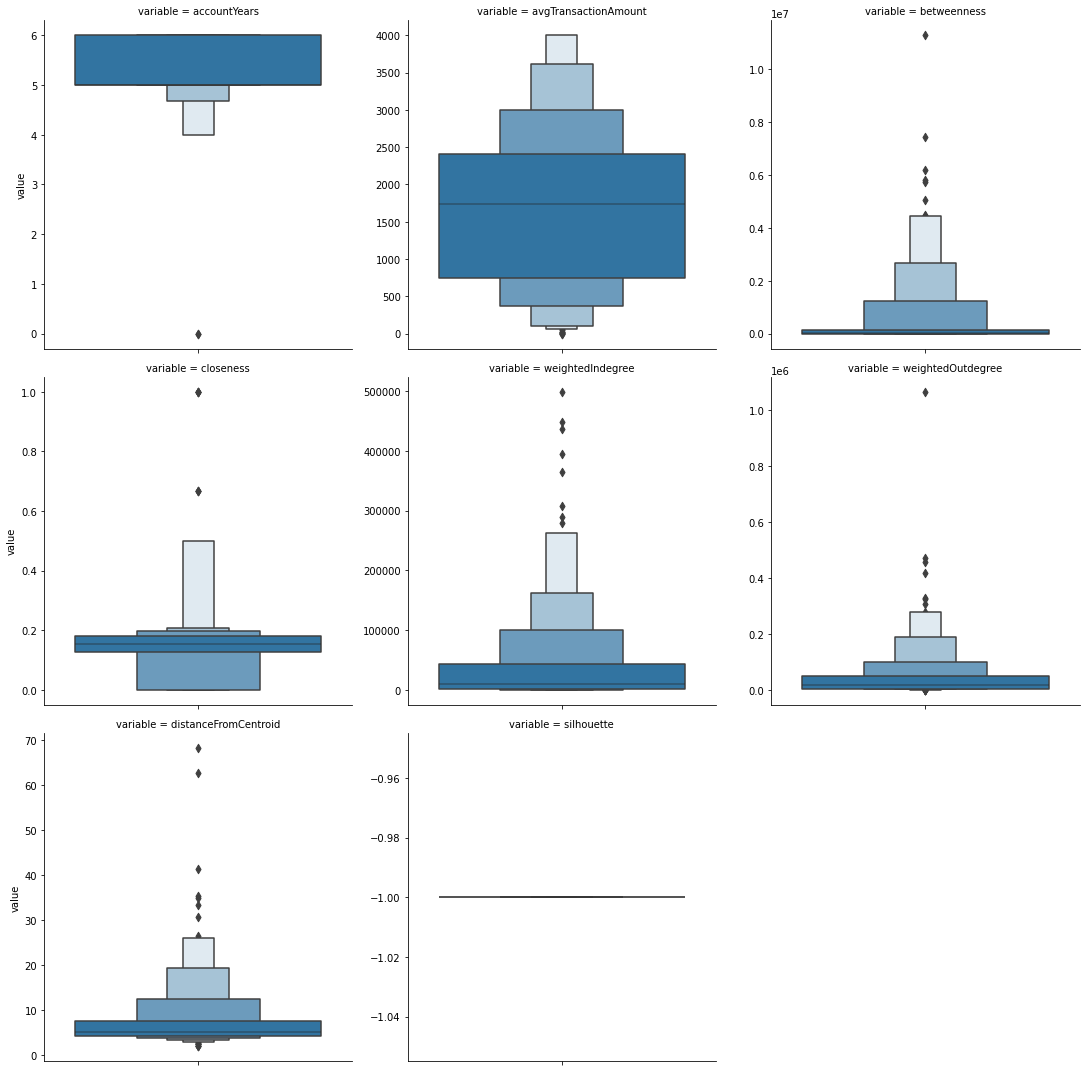

In [19]:
community_4 = (
    merged_df[merged_df["communityId"] == 4]
    .drop("communityId", axis=1)
    .melt(id_vars="nodeId")
)
sns.catplot(
    data=community_4, y="value", col="variable", col_wrap=3, kind="boxen", sharey=False
)

It seems that power users are more or less the oldest accounts. Their average transaction amount usually ranges between 500 to 2500. So they sent a lot of currency to other users but also received a lot of it. Not surprisingly, they have, on average, a high betweenness score. Therefore, we can assume that they connect various communities of users and act as a bridge between them.

Lastly, we will plot the clusters on a scatter plot. In order to achieve this, we need to use a dimensionality reduction algorithm like t-SNE to reduce the feature dimensionality to 2.

<AxesSubplot:xlabel='tsne_x', ylabel='tsne_y'>

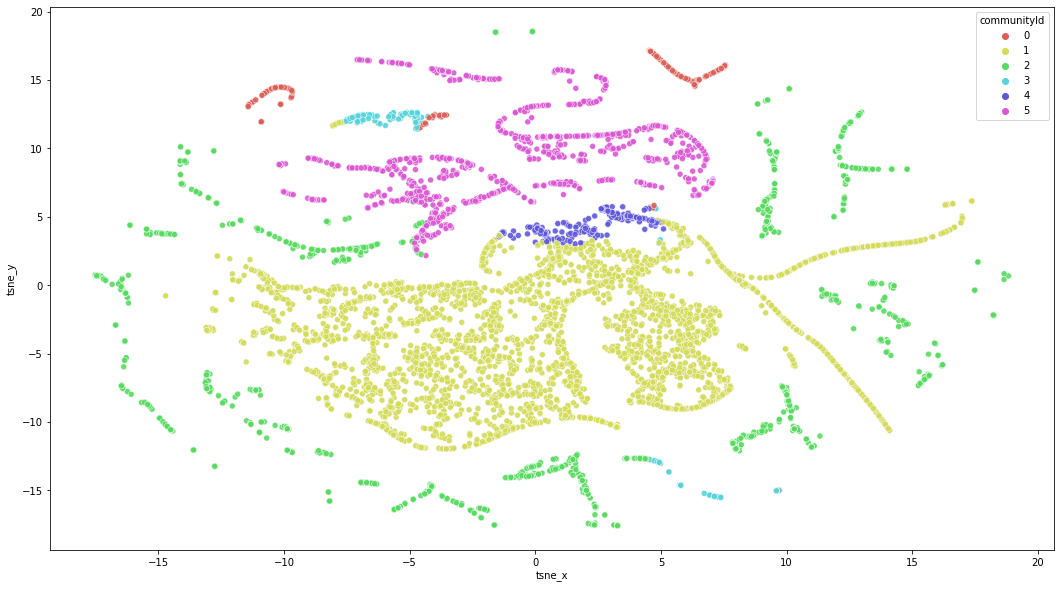

In [20]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

tsne_data = merged_df.drop(["nodeId", "communityId"], axis=1).values.tolist()

scaler = StandardScaler()
scaler.fit(tsne_data)

tsne = TSNE(
    n_components=2, n_iter=500, random_state=42, perplexity=50, learning_rate=20
)
tsne_results = tsne.fit_transform(scaler.transform(tsne_data))

merged_df["tsne_x"] = [x[0] for x in list(tsne_results)]
merged_df["tsne_y"] = [x[1] for x in list(tsne_results)]

plt.figure(figsize=(18, 10))
sns.scatterplot(
    x="tsne_x",
    y="tsne_y",
    hue="communityId",
    palette=sns.color_palette("hls", 6),
    data=merged_df,
    legend="full",
    alpha=0.9,
)

Maybe it is evident from this visualization that our cluster analysis accuracy would benefit from raising the number of clusters by increasing the k value. Another thing you might be asking yourselves is why isn't the split between clusters more distinct. For example, the red community is present on both the left and right sides of the visualization. I attribute this to the t-SNE dimensionality reduction algorithm. If we were to run the k-means algorithm on only two features, we should get a nice distinct split between clusters.

In [21]:
G.drop()
largestComponentGraph.drop()

graphName                                                 largestComponent
database                                                             neo4j
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                            11311
relationshipCount                                                    52272
configuration            {'jobId': '36a5f9cd-005a-41d5-838f-6cb665d09f8...
density                                                           0.000409
creationTime                           2023-02-01T13:18:11.499292052+01:00
modificationTime                       2023-02-01T13:19:23.300208879+01:00
schema                   {'graphProperties': {}, 'relationships': {'P2P...
schemaWithOrientation    {'graphProperties': {}, 'relationships': {'P2P...
Name: 0, dtype: object